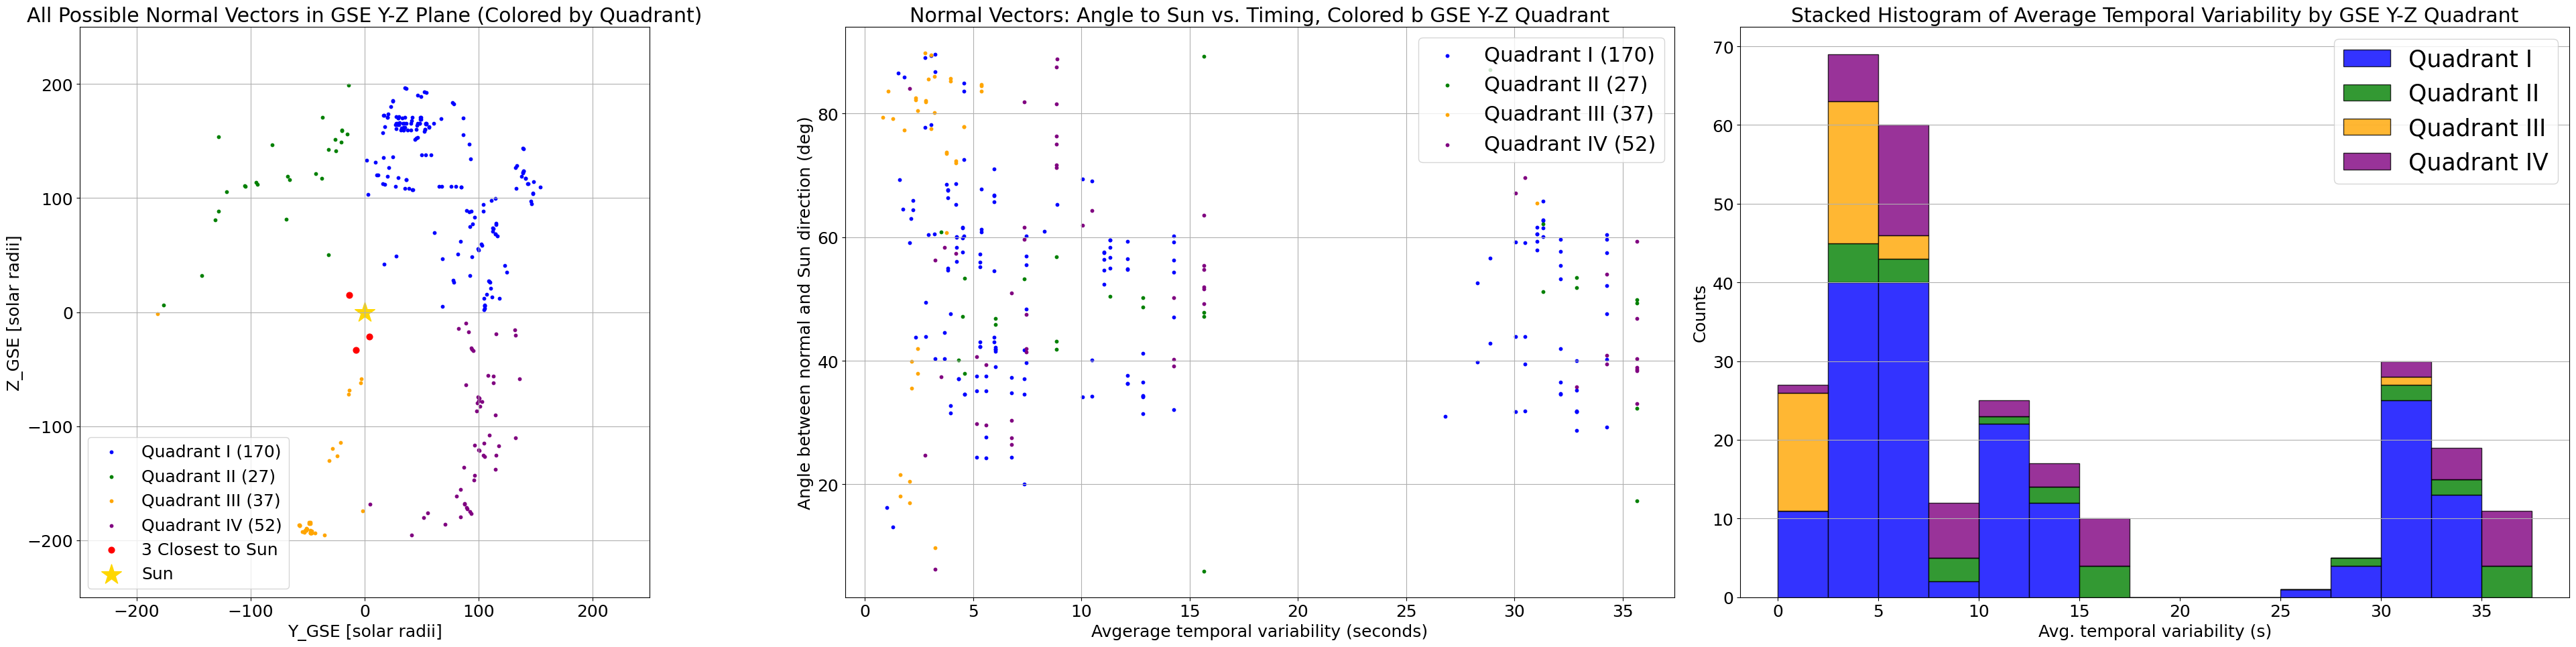

In [44]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
from datetime import datetime
import spiceypy as spice

# Load SPICE kernels (assumed in current directory, download these from NASA JPL: https://ssd.jpl.nasa.gov/ephem.html)
spice.furnsh("naif0012.tls")
spice.furnsh("de421.bsp")
spice.furnsh("earth_latest_high_prec.bpc")

# Function to convert degrees to radians
def deg2rad(deg):
    return deg * np.pi / 180.0

# Function to convert geodetic (Earth lat/lon to Earth Centered Earth Fixed Coordinates (ECEF)) 
def geodetic_to_ecef(lat, lon, alt):
    a = 6378137.0
    f = 1 / 298.257223563
    b = a * (1 - f)
    lat = deg2rad(lat)
    lon = deg2rad(lon)
    N = a / np.sqrt(1 - (2*f - f**2) * np.sin(lat)**2)
    x = (N + alt) * np.cos(lat) * np.cos(lon)
    y = (N + alt) * np.cos(lat) * np.sin(lon)
    z = ((b**2/a**2) * N + alt) * np.sin(lat)
    return np.array([x, y, z])

# Function to calculate a normal vector for a plane fit through three locations
def plane_normal(p1, p2, p3):
    v1 = p2 - p1
    v2 = p3 - p1
    normal = np.cross(v1, v2)
    norm = np.linalg.norm(normal)
    return normal / norm if norm != 0 else normal

# Function to convert Right Ascension and Declination coordinates to ECEF 
def radec_to_ecef(ra_deg, dec_deg):
    ra = deg2rad(ra_deg)
    dec = deg2rad(dec_deg)
    x = np.cos(dec) * np.cos(ra)
    y = np.cos(dec) * np.sin(ra)
    z = np.sin(dec)
    return np.array([x, y, z])

# Function to read the different times from each station
def parse_time(timestr):
    return datetime.strptime(timestr, "%H:%M:%S.%f") if '.' in timestr \
           else datetime.strptime(timestr, "%H:%M:%S")

# ---- Station data ---- (Insert your own station data here with name, latitude, longitude, and elevation in meters) 
stations = [
    ("MEXICO-LANCE", 19.47999954, -101.4100037, 2524, "16:55:21.52625"),
    ("GLASGOW", 55.90000153, -4.300000191, 53, "16:55:23.61500"),
    ("GREENLAND", 66.97000122, -50.95000076, 34, "16:55:25.71875"),
    ("NORWAY-EGERSUND", 58.41999, 5.9699, 8, "16:55:26.81500"),
    ("ALASKA_COHOE", 60.36999893, -151.3200073, 22, "16:55:28.01000"),
    ("ALASKA-HAARP", 62.40000153, -145.1699982, 582, "16:55:28.43125"),
    ("SWISS_LANDSCHLACHT", 47.63000107, 9.239999771, 406, "16:55:29.25750"),
    ("SWISS-HEITERSWIL", 47.29999924, 9.130000114, 904, "16:55:29.93500"),
    ("GERMANY-ESSEN", 51.39379883, 6.979000092, 121, "16:55:31.66625"),
    ("BIR", 53.09, -7.92, 42, "16:55:32.58000"),
    ("USA-BOSTON", 42.61, -71.48, 88, "16:55:34.78750"),
    ("Peach Mountain", 42.40393165, -83.9243604, 315, "16:55:45"),
    ("Marquette Senior HS", 46.55647077, -87.41439282, 222, "16:56:15"),
]

# Convert station coordinates 
ecef_coords = np.array([geodetic_to_ecef(lat, lon, elev) for (_, lat, lon, elev, _) in stations])

# Read station times 
station_times = [parse_time(st[-1]) for st in stations]

# ---- Sun/GSE axes ----
utc_time = "2024-08-05T16:55:00" # Enter the time and date of you burst here to get Sun's position at the time 
et = spice.utc2et(utc_time)
sun_pos_ecef, _ = spice.spkpos("SUN", et, "ITRF93", "NONE", "EARTH")
sun_vec_ecef = np.array(sun_pos_ecef) / np.linalg.norm(sun_pos_ecef)
gse_z = radec_to_ecef(270, 66.5607)
gse_z -= np.dot(gse_z, sun_vec_ecef) * sun_vec_ecef
gse_z /= np.linalg.norm(gse_z)
gse_y = np.cross(gse_z, sun_vec_ecef)
gse_y /= np.linalg.norm(gse_y)
gse_basis = np.vstack([sun_vec_ecef, gse_y, gse_z]).T  # ECEF -> GSE

# ---- Iterate all triangles ----
gse_normals = []
avg_time_diffs = []
angles_deg = []
quadrants = []
triplet_names = []

# Do all the combinations of three stations to get many normal vectors (conversion to GSE happens here too) 
for idxs in itertools.combinations(range(len(stations)), 3):
    i1, i2, i3 = idxs
    # Geometry
    p1, p2, p3 = ecef_coords[[i1, i2, i3]]
    normal_ecef = plane_normal(p1, p2, p3)
    normal_gse = gse_basis.T @ normal_ecef  # Transform to GSE
    # Make sure positive x so you point towards the Sun
    if normal_gse[0] < 0:
        normal_gse = -normal_gse
    y, z = normal_gse[1], normal_gse[2]
    # Find the quadrant each normal is in 
    if y > 0 and z > 0:
        quadrant = 1
    elif y < 0 and z > 0:
        quadrant = 2
    elif y < 0 and z < 0:
        quadrant = 3
    elif y > 0 and z < 0:
        quadrant = 4
    else:
        quadrant = 0
    angle = np.arccos(np.clip(normal_gse[0], -1, 1)) * 180/np.pi
   
    # Calculate average temporal variability: average difference in timing for a set of 3 stations 
    t1, t2, t3 = station_times[i1], station_times[i2], station_times[i3]
    dt21 = abs((t2-t1).total_seconds())
    dt31 = abs((t3-t1).total_seconds())
    dt32 = abs((t3-t2).total_seconds())
    avg_dt = (dt21 + dt31 + dt32) / 3
    triplet_names.append(tuple(stations[k][0] for k in idxs))
    gse_normals.append(normal_gse)
    avg_time_diffs.append(avg_dt)
    angles_deg.append(angle)
    quadrants.append(quadrant)

# Save data
gse_normals = np.array(gse_normals)
avg_time_diffs = np.array(avg_time_diffs)
angles_deg = np.array(angles_deg)
quadrants = np.array(quadrants)

# Find indices for 3 triangles whose normal is closest to Sun (largest x)
dot_with_sun = gse_normals[:, 0]
closest_idx = np.argsort(-dot_with_sun)[:3]

# ---- Plotting setup ----
plt.rcParams.update({'font.size': 18})
fig, axs = plt.subplots(1, 3, figsize=(40, 10))

# --- Plot 1: GSE Y-Z plane of normals ---
colors_gse = ['black', 'blue', 'green', 'orange', 'purple']
labels_gse = ['', 'Quadrant I', 'Quadrant II', 'Quadrant III', 'Quadrant IV']
# Scale for visibility 
all_y = gse_normals[:, 1] * 200
all_z = gse_normals[:, 2] * 200

for q in range(1, 5):
    idx = quadrants == q
    axs[0].scatter(all_y[idx], all_z[idx], s=10, color=colors_gse[q], label=f"{labels_gse[q]} ({np.sum(idx)})")
axs[0].scatter(all_y[closest_idx], all_z[closest_idx], color='red', s=40, label="3 Closest to Sun", zorder=5)
axs[0].scatter(0, 0, color='gold', s=500, marker='*', label="Sun")
axs[0].set_xlabel("Y_GSE [solar radii]")
axs[0].set_ylabel("Z_GSE [solar radii]")
axs[0].set_title("All Possible Normal Vectors in GSE Y-Z Plane (Colored by Quadrant)")
axs[0].set_aspect('equal')
axs[0].set_xlim(-250, 250)
axs[0].set_ylim(-250, 250)
axs[0].legend(fontsize=18, loc='lower left')
axs[0].grid(True)

# --- Plot 2: Angle to Sun vs. avg time diff ---
colors2 = ['black', 'blue', 'green', 'orange', 'purple']
labels2 = ['', 'Quadrant I', 'Quadrant II', 'Quadrant III', 'Quadrant IV']
for q in range(1, 5):
    idx = (quadrants == q)
    axs[1].scatter(avg_time_diffs[idx], angles_deg[idx], color=colors2[q], s=10, label=f"{labels2[q]} ({np.sum(idx)})")
axs[1].set_xlabel("Avgerage temporal variability (seconds)")
axs[1].set_ylabel("Angle between normal and Sun direction (deg)")
axs[1].set_title("Normal Vectors: Angle to Sun vs. Timing, Colored b GSE Y-Z Quadrant")
axs[1].legend(fontsize=22, loc='upper right')
axs[1].grid(True)

# --- Plot 3: Stacked histogram of avg time diff by quadrant ---
colors3 = ['blue', 'green', 'orange', 'purple']
labels3 = ['Quadrant I', 'Quadrant II', 'Quadrant III', 'Quadrant IV']
bin_width = 2.5
bin_edges = np.arange(0, np.ceil(np.max(avg_time_diffs)/bin_width)*bin_width + bin_width, bin_width)
data_by_quadrant = [avg_time_diffs[quadrants == (q+1)] for q in range(4)]
axs[2].hist(data_by_quadrant, bins=bin_edges, color=colors3, alpha=0.8, edgecolor='black', label=labels3, stacked=True)
axs[2].set_xlabel("Avg. temporal variability (s)")
axs[2].set_ylabel("Counts")
axs[2].set_title("Stacked Histogram of Average Temporal Variability by GSE Y-Z Quadrant")
axs[2].legend(fontsize=25)
axs[2].grid(axis='y')

plt.tight_layout()
plt.show()

spice.kclear()
